# **Audio Pre-processing**

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
#Connecting to drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!du -sh drive/MyDrive/Week4/data/*

2.4G	drive/MyDrive/Week4/data/AMHARIC
1.4G	drive/MyDrive/Week4/data/SWAHILI


### **Setting the working directory**

In [31]:
import os
os.chdir("/content/drive/MyDrive/Week4/data/AMHARIC/data/train")
os.listdir()

['spk2utt', 'text', 'trsTrain.txt', 'utt2spk', 'wav.scp', 'wav']

In [35]:
len(os.listdir('wav/'))

10875

>`Our data set has 10875 audio files.`

In [ ]:
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

### **LOAD AUDIO DATA**

In [ ]:
train_audio_path = 'train/wav/' 
samples,sample_rate = librosa.load(train_audio_path + 'tr_1_tr01001.wav')
print(samples)
print(sample_rate)

[-0.00502738 -0.00577551 -0.0046026  ... -0.00579655 -0.00516981
  0.        ]
22050


In [ ]:
audio, rate=librosa.load(train_audio_path+'tr_1_tr01001.wav', sr=44100)

In [ ]:
ipd.Audio(samples, rate=sample_rate)

In [42]:
def load_audio_files(path : str, sampling_rate : int, to_mono : bool):

  """
  Load the audio files and produce a dictionary mapping the audio filenames 
  to numpy arrays of the audio sampled at the given sample rate.

  Inputs: 
  path - a path to the directory that contains the audio files
  sample_rate - the sampling rate for the audio files
  to_mono - a boolean value denoting whether to convert signal to mono

  Returns:
  audio_files - audios - a dictionary mapping the wav file names to the sampled audio array
  max_length - the maximum length of a sampled audio array in our dataset
  """

  audio_files = {}
  max_length = 0
  i = 0
  for file in os.listdir(path):
    audio, rate= librosa.load(path+file, sr=sampling_rate, mono = to_mono)
    audio_files[file.split('.')[0]] = audio
    max_length = max(max_length,len(audio))
    i+=1
    if i%20 == 0:
      print('loaded',i,'audio files')
    if i == 100:
      break
  return audio_files, max_length

audio_files, maximum_length = load_audio_files('wav/', sample_rate, True)

loaded 20 audio files
loaded 40 audio files
loaded 60 audio files
loaded 80 audio files
loaded 100 audio files


In [44]:
print("The longest audio is",maximum_length/sample_rate, 'seconds long')

The longest audio is 16.128027210884355 seconds long


### **LOAD TRANSCRIPT DATA**

In [40]:
def load_transcripts(filepath : str) -> dict:
  """
  Load the transcript file and produce a dictionary mapping the audio filenames 
  to the transcripts for those audio files.

  Inputs: 
  filepath - a path to the transcript file

  Returns:
  transcripts - a python dictionary mapping the wav file names to the transcripts
                of those audio files.
  """
  transcripts = {}
  with open (filepath, encoding="utf-8")as f:
    #print(f.readlines()[1])
    for line in f.readlines():
      
      text, filename = line.split("</s>")
      text, filename = text.strip()[3:], filename.strip()[1:-1]
      transcripts[filename] = text
    return transcripts

transcripts = load_transcripts("trsTrain.txt")

In [43]:
maximum_length

355623

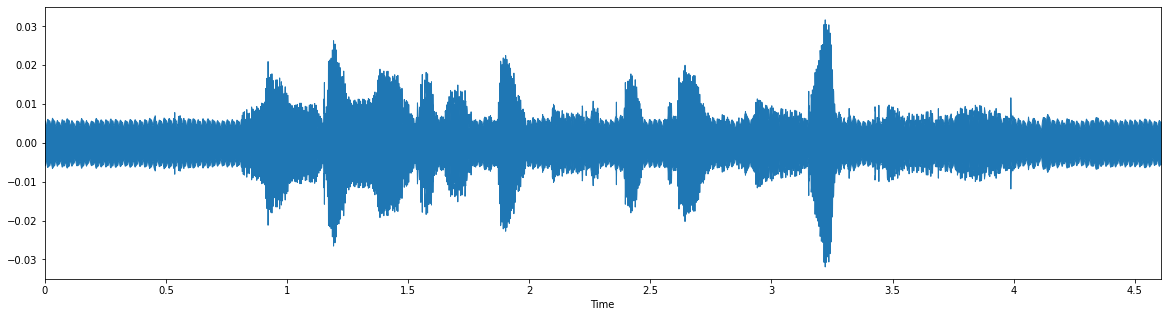

In [ ]:
%matplotlib inline
import librosa.display
#Plot the signal:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(samples, sr=sample_rate)

In [46]:
demo_audio = list(audio_files.keys())[1]

In [47]:
ipd.Audio(audio_files[demo_audio], rate=sample_rate)

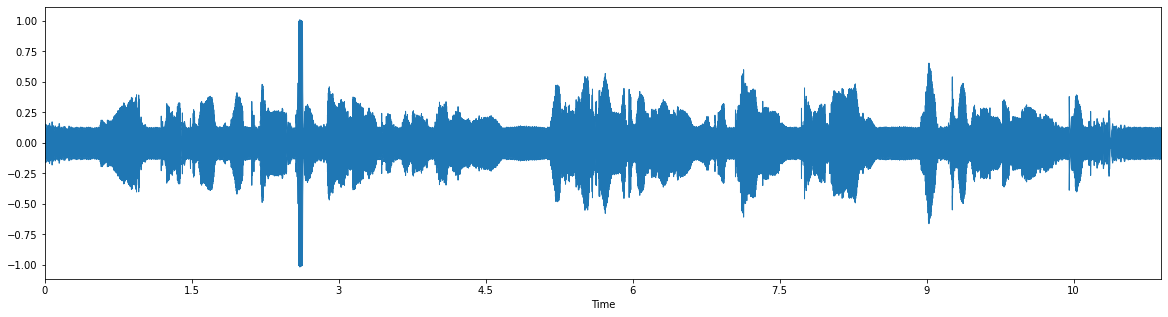

In [50]:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(audio_files[demo_audio], sr=sample_rate)

In [49]:
transcripts[demo_audio]

' ይህ ት ምርት ቤት የ ቀኝ ክንፍ ሀይማኖ ቶችን አላማ የሚ ያራምድ በመሆኑ ኢትዮጵያ ን ን አ ይሁዳውያን ናቸው ብሎ እንደማያ ም ን ታውቋል'

In [ ]:
from numpy.lib.stride_tricks import as_strided
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [ ]:
spe_samples,frequency=spectrogram(samples)

In [ ]:
frequency

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

In [ ]:
spe_samples

array([[1.76332217e-03, 2.75115201e-03, 2.59518971e-03, ...,
        2.30338586e-03, 1.59972883e-03, 2.36620903e-03],
       [8.27526690e-04, 1.48350486e-03, 1.33823861e-03, ...,
        1.21430866e-03, 7.00716316e-04, 1.31378762e-03],
       [2.86930759e-06, 1.92337456e-06, 3.61349402e-08, ...,
        3.54633404e-07, 4.78659698e-06, 5.78052387e-06],
       ...,
       [6.71118643e-17, 4.33052209e-19, 3.63256681e-18, ...,
        1.55272595e-19, 5.21457061e-18, 9.12951217e-20],
       [1.72332657e-16, 2.51864806e-18, 3.12430283e-18, ...,
        6.62812802e-18, 3.57302015e-18, 2.60651918e-18],
       [3.35206898e-17, 1.30404485e-18, 1.55713733e-18, ...,
        5.52245060e-19, 1.04002583e-18, 2.38001449e-19]])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

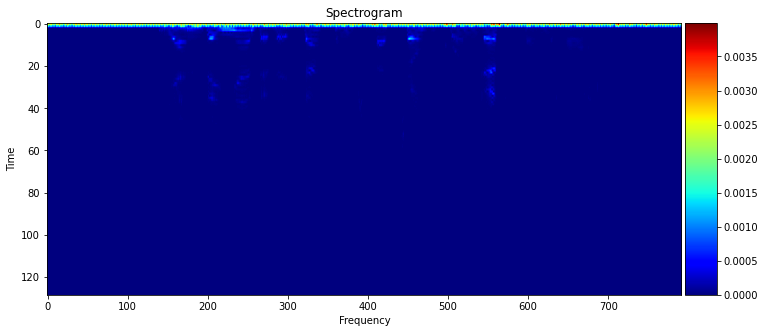

In [ ]:
plot_spectrogram_feature(spe_samples)

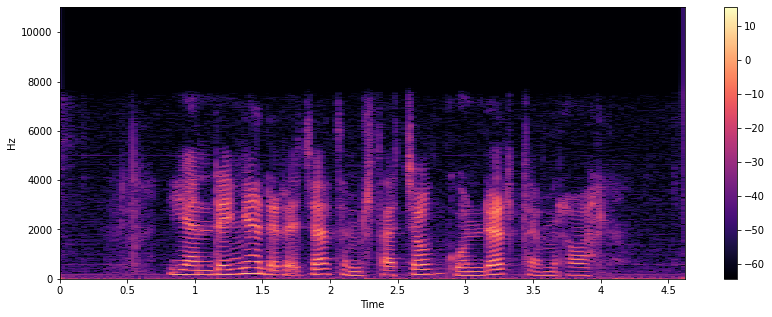

In [ ]:
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

### **Data Augumentation**

In [54]:
def augment_audio(audios : dict, sample_rate : int) -> dict:
  
#shift the wave by sample_rate/10 factor.
#audios - a dictionary mapping the wav file names to the sampled audio array
#sample_rate - the sample rate for the audio
#audios - a python dictionary mapping the wav file names to the augmented audio samples
  for name in audios:
    audios[name] = np.roll(audios[name], int(sample_rate/10))
  return audios

augment_audio(audio_files, sample_rate)[demo_audio].shape

(251194,)

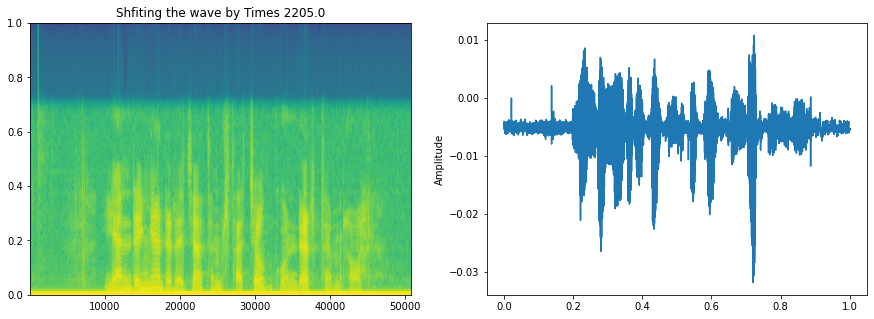

In [53]:
def plot_spec(data:np.array,sr:int) -> None:
  '''
  Function for plotting spectrogram along with amplitude wave graph
  '''
  
  fig, ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].title.set_text(f'Shfiting the wave by Times {sr/10}')
  ax[0].specgram(data,Fs=2)
  ax[1].set_ylabel('Amplitude')
  ax[1].plot(np.linspace(0,1,len(data)), data)

wav_roll = np.roll(samples,int(sample_rate/10))
plot_spec(data=wav_roll,sr=sample_rate)
ipd.Audio(wav_roll,rate=sample_rate)